In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 128

In [3]:
file_name = 'wheat_12_var_avg_new.csv'

def dir(file_name):
    return '../data/'+file_name

In [4]:
def seperate_X_Y(dataframe):
    return (dataframe.drop('classes', axis =1), dataframe.loc[:,'classes'])

In [5]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3

FILT = 3
FILTER = filter_method(FILT).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = 1

#will be used for test dataset in msc
reference= None

In [6]:
from sklearn.model_selection import train_test_split
def create_test_train(X, y, test_size = 0.2, shuffle = True):
    return train_test_split(X,y, test_size = test_size, shuffle=shuffle)

In [7]:
#Standard Normal Variate
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

In [8]:
# Multiplicative scatter correction
def msc(input_data, reference=None):
#     print(reference)
    ''' Perform Multiplicative scatter correction'''

    # Baseline correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        matm = np.mean(input_data, axis=0)
    else:
        matm = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(matm, input_data[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 

    return (output_data, matm)

In [9]:
from scipy.signal import savgol_filter, general_gaussian
def savgol(input_data):
    w = WINDOW
    p = ORDER
    d = DERIVATIVE
    
    output_data = savgol_filter(np.array(input_data), w, polyorder = p, deriv=d)
    
    return output_data

In [10]:
def preprocess_data(X,y, type="train"):
    if FILTER == "snv":
        return {"X": snv(np.array(X)), "y": y}
    elif FILTER == "msc":
        msc_output = msc(np.array(X), reference = reference if type=="test" else None)
        X = msc_output[0]
        ref = msc_output[1]
        return {
            "X": X,
            "y": y,
            "ref": ref
        }
    elif FILTER == "savgol":
        return {
            "X": savgol(X),
            "y": y
        }
    else:
        return {
            "X":X,
            "y":y
        }

In [11]:
dataset = pd.read_csv(dir(file_name))
X,y = seperate_X_Y(dataset)

In [12]:
y_set = set(y)

In [13]:
NUM_OF_CLASSES = len(y_set)

In [14]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = create_test_train(X,y)

In [15]:
preprocessed_results = preprocess_data(X_train_raw,y_train_raw)
X_train, y_train = preprocessed_results["X"], preprocessed_results["y"]

if FILTER == "msc":
    reference = preprocessed_results["ref"]
    
preprocessed_results_test = preprocess_data(X_test_raw, y_test_raw, type="test")
X_test, y_test = preprocessed_results_test["X"], preprocessed_results_test["y"]

In [16]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_test.shape)

(19353, 147, 1)
(4839, 147, 1)


In [17]:
import keras
from keras import Sequential
from keras.layers import Input, Conv1D, Flatten, Dense, MaxPooling1D

In [18]:
def createModel(input_shape,num_classes):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=5 ))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    
    return model

In [19]:
model = createModel(X_train.shape[1:],NUM_OF_CLASSES)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 143, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 28, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense (Dense)               (None, 1000)              897000    
                                                                 
 dense_1 (Dense)             (None, 4)                 4004      
                                                                 
Total params: 901,196
Trainable params: 901,196
Non-trainable params: 0
__________________________________________________

In [21]:
train_eva = []
test_eva = []

In [22]:
history_dataframe = pd.DataFrame() 

In [23]:
for x in range(400):
    print("\nEpoch: ",x+1)
    history = model.fit(X_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    
    print("for training")
    train_eva.append(model.evaluate(X_train,y_train))
    print("for testing")
    test_eva.append(model.evaluate(X_test, y_test))


Epoch:  1
152/152 - 4s - loss: 1.3454 - accuracy: 0.3286 - 4s/epoch - 25ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 1.2633 - accuracy: 0.3884
for testing
152/152 [==============================] - 1s 4ms/step - loss: 1.2657 - accuracy: 0.3827

Epoch:  2
152/152 - 3s - loss: 1.2544 - accuracy: 0.3985 - 3s/epoch - 21ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 1.2373 - accuracy: 0.3931
for testing
152/152 [==============================] - 1s 4ms/step - loss: 1.2349 - accuracy: 0.3966

Epoch:  3
152/152 - 3s - loss: 1.2291 - accuracy: 0.4252 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 1.2085 - accuracy: 0.4200
for testing
152/152 [==============================] - 1s 4ms/step - loss: 1.2073 - accuracy: 0.4166

Epoch:  4
152/152 - 3s - loss: 1.1924 - accuracy: 0.4515 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 3s 4ms/step

152/152 [==============================] - 1s 4ms/step - loss: 0.3429 - accuracy: 0.8721

Epoch:  30
152/152 - 3s - loss: 0.3038 - accuracy: 0.8867 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.3047 - accuracy: 0.8840
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.3078 - accuracy: 0.8859

Epoch:  31
152/152 - 3s - loss: 0.2903 - accuracy: 0.8923 - 3s/epoch - 22ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.2982 - accuracy: 0.8889
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.3029 - accuracy: 0.8861

Epoch:  32
152/152 - 3s - loss: 0.2834 - accuracy: 0.8948 - 3s/epoch - 21ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.2899 - accuracy: 0.8926
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.2927 - accuracy: 0.8907

Epoch:  33
152/152 - 3s - loss: 0.2808 - accuracy: 0.89

605/605 [==============================] - 2s 4ms/step - loss: 0.1418 - accuracy: 0.9519
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.1517 - accuracy: 0.9442

Epoch:  59
152/152 - 3s - loss: 0.1496 - accuracy: 0.9480 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.1417 - accuracy: 0.9517
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.1526 - accuracy: 0.9452

Epoch:  60
152/152 - 3s - loss: 0.1419 - accuracy: 0.9505 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.1392 - accuracy: 0.9522
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.1489 - accuracy: 0.9469

Epoch:  61
152/152 - 3s - loss: 0.1426 - accuracy: 0.9499 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.1422 - accuracy: 0.9510
for testing
152/152 [==============================] - 1

for training
605/605 [==============================] - 2s 4ms/step - loss: 0.1032 - accuracy: 0.9644
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.1159 - accuracy: 0.9601

Epoch:  88
152/152 - 3s - loss: 0.1081 - accuracy: 0.9639 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.1258 - accuracy: 0.9548
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.1420 - accuracy: 0.9494

Epoch:  89
152/152 - 3s - loss: 0.1068 - accuracy: 0.9633 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.1037 - accuracy: 0.9626
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.1133 - accuracy: 0.9618

Epoch:  90
152/152 - 3s - loss: 0.1084 - accuracy: 0.9624 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.1019 - accuracy: 0.9641
for testing
152/152 [======================

152/152 [==============================] - 1s 4ms/step - loss: 0.0954 - accuracy: 0.9665

Epoch:  116
152/152 - 3s - loss: 0.0934 - accuracy: 0.9671 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.1027 - accuracy: 0.9634
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.1103 - accuracy: 0.9616

Epoch:  117
152/152 - 3s - loss: 0.0887 - accuracy: 0.9697 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0838 - accuracy: 0.9711
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0991 - accuracy: 0.9669

Epoch:  118
152/152 - 3s - loss: 0.0918 - accuracy: 0.9688 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0980 - accuracy: 0.9648
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.1184 - accuracy: 0.9607

Epoch:  119
152/152 - 3s - loss: 0.0917 - accuracy: 

605/605 [==============================] - 2s 4ms/step - loss: 0.1091 - accuracy: 0.9623
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.1190 - accuracy: 0.9580

Epoch:  145
152/152 - 3s - loss: 0.0815 - accuracy: 0.9714 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0795 - accuracy: 0.9719
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0969 - accuracy: 0.9661

Epoch:  146
152/152 - 3s - loss: 0.0739 - accuracy: 0.9748 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0727 - accuracy: 0.9744
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0857 - accuracy: 0.9711

Epoch:  147
152/152 - 3s - loss: 0.0792 - accuracy: 0.9719 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.1164 - accuracy: 0.9585
for testing
152/152 [==============================] 

152/152 [==============================] - 1s 4ms/step - loss: 0.0738 - accuracy: 0.9752

Epoch:  173
152/152 - 3s - loss: 0.0669 - accuracy: 0.9770 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0665 - accuracy: 0.9775
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0789 - accuracy: 0.9713

Epoch:  174
152/152 - 3s - loss: 0.0672 - accuracy: 0.9769 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0638 - accuracy: 0.9790
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0771 - accuracy: 0.9731

Epoch:  175
152/152 - 3s - loss: 0.0674 - accuracy: 0.9771 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0624 - accuracy: 0.9778
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0769 - accuracy: 0.9733

Epoch:  176
152/152 - 3s - loss: 0.0664 - accuracy: 

605/605 [==============================] - 2s 4ms/step - loss: 0.0543 - accuracy: 0.9812
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0669 - accuracy: 0.9760

Epoch:  202
152/152 - 3s - loss: 0.0605 - accuracy: 0.9783 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0572 - accuracy: 0.9802
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0732 - accuracy: 0.9742

Epoch:  203
152/152 - 3s - loss: 0.0607 - accuracy: 0.9792 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0550 - accuracy: 0.9811
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0697 - accuracy: 0.9769

Epoch:  204
152/152 - 3s - loss: 0.0602 - accuracy: 0.9789 - 3s/epoch - 20ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0603 - accuracy: 0.9791
for testing
152/152 [==============================] 

152/152 [==============================] - 1s 4ms/step - loss: 0.0629 - accuracy: 0.9808

Epoch:  230
152/152 - 3s - loss: 0.0568 - accuracy: 0.9801 - 3s/epoch - 21ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0445 - accuracy: 0.9849
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0579 - accuracy: 0.9816

Epoch:  231
152/152 - 3s - loss: 0.0517 - accuracy: 0.9814 - 3s/epoch - 21ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0646 - accuracy: 0.9773
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0803 - accuracy: 0.9680

Epoch:  232
152/152 - 3s - loss: 0.0525 - accuracy: 0.9819 - 3s/epoch - 21ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0498 - accuracy: 0.9815
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0641 - accuracy: 0.9791

Epoch:  233
152/152 - 3s - loss: 0.0542 - accuracy: 

605/605 [==============================] - 2s 4ms/step - loss: 0.0501 - accuracy: 0.9830
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0614 - accuracy: 0.9783

Epoch:  259
152/152 - 3s - loss: 0.0500 - accuracy: 0.9821 - 3s/epoch - 21ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0434 - accuracy: 0.9852
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0616 - accuracy: 0.9787

Epoch:  260
152/152 - 3s - loss: 0.0474 - accuracy: 0.9836 - 3s/epoch - 21ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0556 - accuracy: 0.9792
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0720 - accuracy: 0.9744

Epoch:  261
152/152 - 3s - loss: 0.0470 - accuracy: 0.9842 - 3s/epoch - 21ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0383 - accuracy: 0.9874
for testing
152/152 [==============================] 

152/152 [==============================] - 1s 4ms/step - loss: 0.0563 - accuracy: 0.9820

Epoch:  287
152/152 - 3s - loss: 0.0414 - accuracy: 0.9860 - 3s/epoch - 21ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0376 - accuracy: 0.9866
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0509 - accuracy: 0.9841

Epoch:  288
152/152 - 3s - loss: 0.0439 - accuracy: 0.9846 - 3s/epoch - 21ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0406 - accuracy: 0.9854
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0547 - accuracy: 0.9822

Epoch:  289
152/152 - 3s - loss: 0.0470 - accuracy: 0.9835 - 3s/epoch - 23ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0435 - accuracy: 0.9848
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0552 - accuracy: 0.9820

Epoch:  290
152/152 - 3s - loss: 0.0427 - accuracy: 

605/605 [==============================] - 3s 4ms/step - loss: 0.0391 - accuracy: 0.9866
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0553 - accuracy: 0.9826

Epoch:  316
152/152 - 3s - loss: 0.0389 - accuracy: 0.9863 - 3s/epoch - 21ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0382 - accuracy: 0.9867
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0539 - accuracy: 0.9783

Epoch:  317
152/152 - 3s - loss: 0.0405 - accuracy: 0.9856 - 3s/epoch - 21ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0360 - accuracy: 0.9877
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0533 - accuracy: 0.9824

Epoch:  318
152/152 - 3s - loss: 0.0435 - accuracy: 0.9848 - 3s/epoch - 21ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0340 - accuracy: 0.9890
for testing
152/152 [==============================] 

152/152 [==============================] - 1s 4ms/step - loss: 0.0437 - accuracy: 0.9847

Epoch:  344
152/152 - 3s - loss: 0.0347 - accuracy: 0.9888 - 3s/epoch - 21ms/step
for training
605/605 [==============================] - 2s 4ms/step - loss: 0.0340 - accuracy: 0.9886
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0497 - accuracy: 0.9839

Epoch:  345
152/152 - 3s - loss: 0.0326 - accuracy: 0.9891 - 3s/epoch - 21ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0298 - accuracy: 0.9904
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0456 - accuracy: 0.9851

Epoch:  346
152/152 - 3s - loss: 0.0349 - accuracy: 0.9874 - 3s/epoch - 21ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0349 - accuracy: 0.9878
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0482 - accuracy: 0.9841

Epoch:  347
152/152 - 3s - loss: 0.0379 - accuracy: 

605/605 [==============================] - 3s 5ms/step - loss: 0.0327 - accuracy: 0.9891
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0475 - accuracy: 0.9837

Epoch:  373
152/152 - 3s - loss: 0.0334 - accuracy: 0.9885 - 3s/epoch - 23ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0325 - accuracy: 0.9890
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0462 - accuracy: 0.9820

Epoch:  374
152/152 - 3s - loss: 0.0325 - accuracy: 0.9894 - 3s/epoch - 22ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0241 - accuracy: 0.9920
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0397 - accuracy: 0.9872

Epoch:  375
152/152 - 4s - loss: 0.0284 - accuracy: 0.9905 - 4s/epoch - 25ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0294 - accuracy: 0.9891
for testing
152/152 [==============================] 

152/152 [==============================] - 1s 4ms/step - loss: 0.0375 - accuracy: 0.9870


In [24]:
history_dataframe

,loss,accuracy
0,1.345387,0.328580
1,1.254359,0.398543
2,1.229142,0.425154
3,1.192421,0.451455
4,1.132243,0.504315
...,...,...
395,0.031347,0.988684
396,0.028346,0.989769
397,0.034158,0.988012
398,0.028936,0.989511


In [25]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','accuracy'])

In [26]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

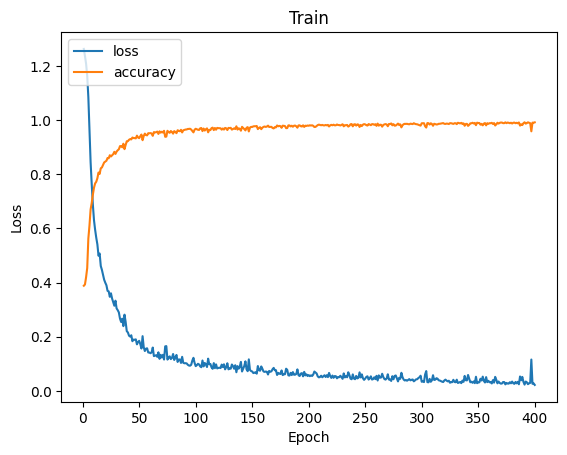

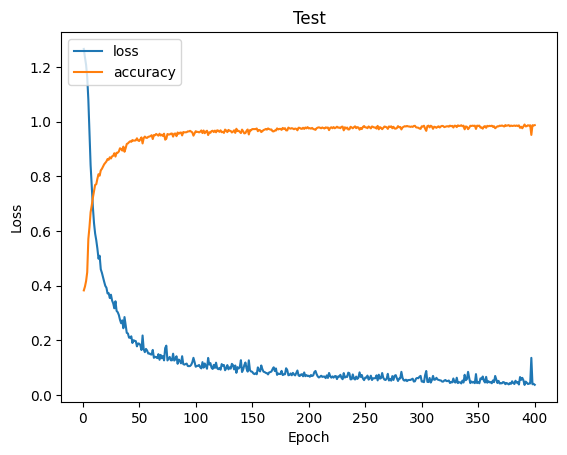

In [27]:
plot_graph(train_eva_df,'Train','Epoch','Loss',['loss','accuracy'])
plot_graph(test_eva_df,'Test','Epoch','Loss',['loss','accuracy'])

In [28]:
for x in range(400,600):
    print("\nEpoch: ",x+1)
    history = model.fit(X_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    
    print("for training")
    train_eva.append(model.evaluate(X_train,y_train))
    print("for testing")
    test_eva.append(model.evaluate(X_test, y_test))


Epoch:  401
152/152 - 4s - loss: 0.0315 - accuracy: 0.9884 - 4s/epoch - 26ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0729 - accuracy: 0.9718
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0976 - accuracy: 0.9682

Epoch:  402
152/152 - 4s - loss: 0.0269 - accuracy: 0.9912 - 4s/epoch - 24ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0274 - accuracy: 0.9905
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0422 - accuracy: 0.9857

Epoch:  403
152/152 - 4s - loss: 0.0294 - accuracy: 0.9893 - 4s/epoch - 24ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0264 - accuracy: 0.9903
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0383 - accuracy: 0.9864

Epoch:  404
152/152 - 3s - loss: 0.0290 - accuracy: 0.9892 - 3s/epoch - 22ms/step
for training
605/605 [==============================] - 3s 

for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0510 - accuracy: 0.9818

Epoch:  430
152/152 - 3s - loss: 0.0287 - accuracy: 0.9893 - 3s/epoch - 22ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0229 - accuracy: 0.9929
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0392 - accuracy: 0.9866

Epoch:  431
152/152 - 3s - loss: 0.0282 - accuracy: 0.9906 - 3s/epoch - 22ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0255 - accuracy: 0.9917
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0428 - accuracy: 0.9837

Epoch:  432
152/152 - 3s - loss: 0.0308 - accuracy: 0.9887 - 3s/epoch - 22ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0246 - accuracy: 0.9921
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0386 - accuracy: 0.9859

Epoch:  433
152/152 - 3s - loss: 0.0294 

605/605 [==============================] - 3s 4ms/step - loss: 0.0369 - accuracy: 0.9857
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0552 - accuracy: 0.9806

Epoch:  459
152/152 - 3s - loss: 0.0285 - accuracy: 0.9899 - 3s/epoch - 22ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0205 - accuracy: 0.9929
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0353 - accuracy: 0.9876

Epoch:  460
152/152 - 3s - loss: 0.0251 - accuracy: 0.9909 - 3s/epoch - 22ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0218 - accuracy: 0.9929
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0388 - accuracy: 0.9864

Epoch:  461
152/152 - 3s - loss: 0.0239 - accuracy: 0.9911 - 3s/epoch - 22ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0216 - accuracy: 0.9923
for testing
152/152 [==============================] 

152/152 [==============================] - 1s 5ms/step - loss: 0.0459 - accuracy: 0.9843

Epoch:  487
152/152 - 4s - loss: 0.0237 - accuracy: 0.9915 - 4s/epoch - 25ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0252 - accuracy: 0.9909
for testing
152/152 [==============================] - 1s 6ms/step - loss: 0.0375 - accuracy: 0.9872

Epoch:  488
152/152 - 3s - loss: 0.0215 - accuracy: 0.9934 - 3s/epoch - 23ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0148 - accuracy: 0.9956
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0304 - accuracy: 0.9905

Epoch:  489
152/152 - 3s - loss: 0.0236 - accuracy: 0.9925 - 3s/epoch - 22ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0687 - accuracy: 0.9739
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0832 - accuracy: 0.9707

Epoch:  490
152/152 - 3s - loss: 0.0252 - accuracy: 

605/605 [==============================] - 3s 4ms/step - loss: 0.0179 - accuracy: 0.9940
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0338 - accuracy: 0.9888

Epoch:  516
152/152 - 3s - loss: 0.0246 - accuracy: 0.9916 - 3s/epoch - 23ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0196 - accuracy: 0.9933
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0325 - accuracy: 0.9878

Epoch:  517
152/152 - 3s - loss: 0.0194 - accuracy: 0.9933 - 3s/epoch - 23ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0318 - accuracy: 0.9880
for testing
152/152 [==============================] - 1s 4ms/step - loss: 0.0449 - accuracy: 0.9853

Epoch:  518
152/152 - 3s - loss: 0.0248 - accuracy: 0.9913 - 3s/epoch - 22ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0161 - accuracy: 0.9948
for testing
152/152 [==============================] 

152/152 [==============================] - 1s 4ms/step - loss: 0.0300 - accuracy: 0.9907

Epoch:  544
152/152 - 3s - loss: 0.0211 - accuracy: 0.9929 - 3s/epoch - 23ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0248 - accuracy: 0.9919
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0384 - accuracy: 0.9862

Epoch:  545
152/152 - 3s - loss: 0.0189 - accuracy: 0.9932 - 3s/epoch - 23ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0215 - accuracy: 0.9919
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0358 - accuracy: 0.9878

Epoch:  546
152/152 - 4s - loss: 0.0209 - accuracy: 0.9930 - 4s/epoch - 23ms/step
for training
605/605 [==============================] - 3s 4ms/step - loss: 0.0181 - accuracy: 0.9946
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0329 - accuracy: 0.9874

Epoch:  547
152/152 - 4s - loss: 0.0205 - accuracy: 

605/605 [==============================] - 3s 5ms/step - loss: 0.0149 - accuracy: 0.9948
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0308 - accuracy: 0.9895

Epoch:  573
152/152 - 4s - loss: 0.0207 - accuracy: 0.9922 - 4s/epoch - 23ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0117 - accuracy: 0.9964
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0274 - accuracy: 0.9905

Epoch:  574
152/152 - 4s - loss: 0.0197 - accuracy: 0.9930 - 4s/epoch - 23ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0136 - accuracy: 0.9957
for testing
152/152 [==============================] - 1s 5ms/step - loss: 0.0273 - accuracy: 0.9897

Epoch:  575
152/152 - 4s - loss: 0.0238 - accuracy: 0.9909 - 4s/epoch - 23ms/step
for training
605/605 [==============================] - 3s 5ms/step - loss: 0.0204 - accuracy: 0.9929
for testing
152/152 [==============================] 

152/152 [==============================] - 1s 5ms/step - loss: 0.0281 - accuracy: 0.9907


In [30]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','accuracy'])

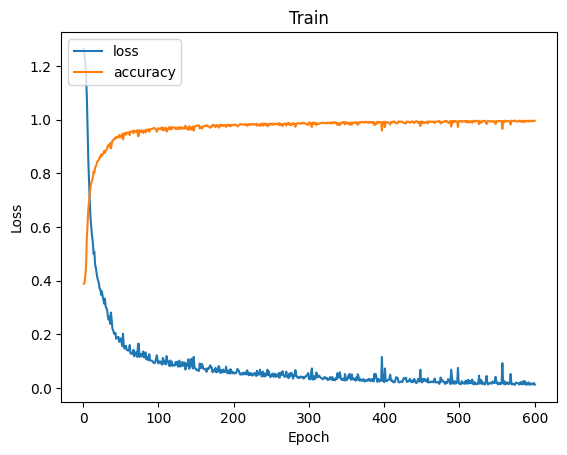

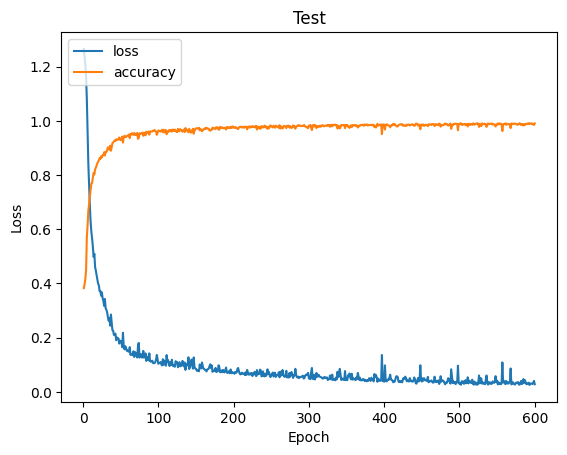

In [31]:
plot_graph(train_eva_df,'Train','Epoch','Loss',['loss','accuracy'])
plot_graph(test_eva_df,'Test','Epoch','Loss',['loss','accuracy'])